In [18]:
from z3 import *
import numpy as np
from itertools import product
from scipy.ndimage import measurements
from skimage.morphology import label
import seaborn as sns
import matplotlib.pyplot as plt
import time
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore", message="Please use `label` from the `scipy.ndimage` namespace")
warnings.filterwarnings("ignore", message="Please use `sum` from the `scipy.ndimage` namespace")

In [19]:
grid = np.array([[0,4,0,0,0,0,0],
                 [0,0,6,3,0,0,6],
                 [0,0,0,0,0,5,5],
                 [0,0,0,4,0,0,0],
                 [4,7,0,0,0,0,0],
                 [2,0,0,7,4,0,0],
                 [0,0,0,0,0,1,0]], dtype=int)

def areas(grid):
  labels, num = measurements.label(grid < 1)
  areas = measurements.sum(grid < 1, labels, index=range(1, num + 1))
  return np.prod(areas)

def print_sol(x):
  _, ax = plt.subplots(1,1,figsize=(8,8))
  y = np.array(x).astype('int').astype('str')
  y[y=="0"] =""
  ax = sns.heatmap(x==0, annot=y, cbar=False, cmap="Greys", fmt="", linewidths=2, center=1, linecolor="grey", annot_kws={"size":14})
  ax.axis("off")
  plt.tight_layout()
  plt.show()
  display(Markdown('## Solution is: {:,.0f}'.format((areas(x)))))

## Solved in 0.084 seconds

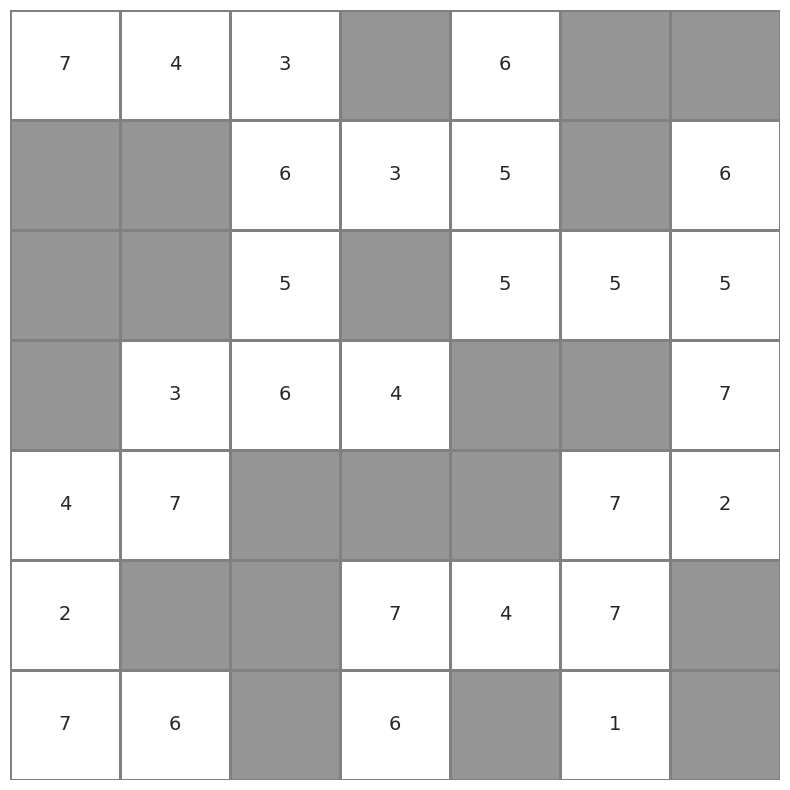

## Solution is: 240

In [21]:
start = time.time()
N = 7
s = Solver()
X = np.array(IntVector("x", N**2), dtype=object).reshape((N,N))

s += [And(n>=0, n<=N) for n in X.ravel()]
s += [X[i][j] == e for (i,j),e in np.ndenumerate(grid) if e != 0]
s += [Sum([X[i][j] for i in range(N)])==20 for j in range(N)]
s += [Sum([X[i][j] for j in range(N)])==20 for i in range(N)]
s += [And(np.sum(X[idx, :])==20, np.sum(X[:, idx])==20) for idx in range(N)]
s += [PbEq([(X[i][j]==0,1) for i in range(N)],3) for j in range(N)]
s += [PbEq([(X[i][j]==0,1) for j in range(N)],3) for i in range(N)]
s += [PbEq([(X[i][j]==n,1) for i,j in product(range(N), repeat=2)],n) for n in range(1,N+1)]
s += [Or(X[i][j]==0,X[i+1][j]==0,X[i][j+1]==0,X[i+1][j+1]==0) for i,j in product(range(N-1), repeat=2)]

while True:   
    if s.check() == sat:
        m = s.model()
        x = np.array([[m.evaluate(X[i][j]).as_long() for j in range(N)] for i in range(N)])
        if np.max(label(x != 0,connectivity=1)) == 1:
            display(Markdown('## Solved in {:.3f} seconds'.format(time.time()-start)))
            print_sol(x)
            break
        s += Or([X[i][j]!=int(x[i,j]) for i,j in product(range(N), repeat=2)])